In [1]:
! pip install --upgrade pytorch-lightning einops astropy nflows

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 720.6/720.6 kB 33.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 35.1 MB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 16.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 741.1/741.1 kB 37.8 MB/s eta 0:00:00
  Created wheel for nflows: filename=nflows-0.14-py3-none-any.whl size=53654 sha256=d336cc14d6cb0251602081cab3337fe33ad759783c04ce789d274bf4a56a95dc
  Stored in directory: /root/.cache/pip/wheels/e1/08/10/19b7420ee82c99f10c57f6b50c982f7416722490133cc85bc3
Successfully built nflows


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, random_split

torch.set_float32_matmul_precision("medium")

from einops import rearrange, repeat
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from tqdm import tqdm
from collections import defaultdict

import sys
sys.path.append("../")

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
from jax.config import config
config.update("jax_enable_x64", True)

In [4]:
from simulators.lensing import LensingSim

## Simulation

In [5]:
def _mag_to_flux(mag, mag_zp):
    """
    Returns total flux of the integrated profile corresponding to magnitude `mag`, in ADU relative to `mag_zp`
    """
    return 10 ** (-0.4 * (mag - mag_zp))

In [14]:
import jax.scipy as jsp

# Lensing image configuration

exposure = 1610.0
n_xy = 64
pixel_size = 0.1 * n_xy / n_xy
mag_zero = 25.5
mag_iso = 22.5
mag_s = 23.0
fwhm_psf = 0.18

coordinate_limit = pixel_size * n_xy / 2.0
f_iso = _mag_to_flux(mag_iso, mag_zero)

observation_dict = {"n_x": n_xy, "n_y": n_xy, "theta_x_lims": (-coordinate_limit, coordinate_limit), "theta_y_lims": (-coordinate_limit, coordinate_limit), "exposure": exposure, "f_iso": f_iso,}

theta_x_0 = 0.
theta_y_0 = 0.
theta_s_e = 0.4

S_tot = _mag_to_flux(mag_s, mag_zero)

global_dict = {"z_s": 1., "z_l": 0.2}
hst_param_dict = {"profile": "SIE", "theta_x_0": 0.12, "theta_y_0": -0.2, "theta_E": 2.15, "q": 0.8}
src_param_dict = {"profile": "Sersic", "theta_x_0": theta_x_0, "theta_y_0": theta_y_0, "S_tot": S_tot, "theta_e": theta_s_e, "n_srsc": 1}

In [15]:
from simulators.units import *
from simulators.lensing_profiles import MassProfileNFW

In [16]:
def _draw_m_sub(n_sub, m_sub_min, m_sub_max, beta):
    """
    Draw subhalo masses from SHMF with slope `beta` and min/max masses `m_sub_min` and `m_sub_max` . Stolen from:
    https://stackoverflow.com/questions/31114330/python-generating-random-numbers-from-a-power-law-distribution
    """
    u = np.random.uniform(0, 1, size=n_sub)
    m_low_u, m_high_u = m_sub_min ** (beta + 1), m_sub_max ** (beta + 1)
    return (m_low_u + (m_high_u - m_low_u) * u) ** (1.0 / (beta + 1.0))

def _draw_sub_coordinates(n_sub, r_min=0.0, r_max=2.5):
    """
    Draw subhalo n_sub coordinates uniformly within a ring r_min < r < r_max
    """
    x_sub = []
    y_sub = []
    while len(x_sub) < n_sub:
        x_candidates = np.random.uniform(low=-r_max, high=r_max, size=n_sub - len(x_sub))
        y_candidates = np.random.uniform(low=-r_max, high=r_max, size=n_sub - len(x_sub))
        r2 = x_candidates ** 2 + y_candidates ** 2
        good = (r2 <= r_max ** 2) * (r2 >= r_min ** 2)
        x_sub += list(x_candidates[good])
        y_sub += list(y_candidates[good])

    return jnp.array(x_sub), jnp.array(y_sub)

In [17]:
from jax import jit

@jit 
def simulate(sample, key=jax.random.PRNGKey(136)):
    
    src_param_dict = {"profile": "Sersic", "theta_x_0": 0., "theta_y_0": 0., "S_tot": S_tot, "theta_e": 0.4, "n_srsc": 1}
    hst_param_dict = {"profile": "SIE", "theta_x_0": sample['theta_x'], "theta_y_0": sample['theta_y'], "theta_E": sample['theta_E'], "q": sample['q']}
            
    lens_list = [hst_param_dict]
    
    z_x, z_c, z_c_tot = sample['z_x'], sample['z_c'], sample['z_c_tot']
    
    subs_list = []
    for z_i in jnp.arange(n_ps_sim_max):
                        
        m = 10 ** z_c[z_i].astype(float) * M_s
        c = MassProfileNFW.c_200_SCP(m)
        r_s, rho_s = MassProfileNFW.get_r_s_rho_s_NFW(m, c)
                    
        sub_param_dict = {"profile": "NFW", "theta_x_0": z_x[z_i, 0], "theta_y_0": z_x[z_i, 1], "M_200": m, "r_s": r_s, "rho_s": rho_s}
        
        subs_list.append(sub_param_dict)
        
    lsi = LensingSim(lens_list, subs_list, [src_param_dict], global_dict, observation_dict)
    image_smoothed = lsi.lensed_image()
    
    key, subkey = jax.random.split(key)
    image = jax.random.poisson(key, image_smoothed)

    return {'beta': sample['beta'], 'Sigma_sub': sample['Sigma_sub'], 'z_c_tot': z_c_tot, "theta_x": sample['theta_x'], "theta_y": sample['theta_y'], "theta_E": sample['theta_E'], "q": sample['q'], 'x': image.T}

In [120]:
n_set_max = 4
n_sim = 2
n_ps_sim_max = 200

subs_trees = []
sample_trees = []

n_sample_list = []

for i in tqdm(range(n_sim)):
        
    n_sample = n_set_max
    n_sample_list.append(n_sample)
    
    # Draw "global" parameters
    beta = np.random.uniform(-2.1, -1.9)
    Sigma_sub = np.random.uniform(0., 8.)

    # Draw "local" parameters
    for i_sample in range(n_sample):

        if i == 0:
            sample_local = {'theta_x': 0.05 , 'theta_y': -0.05, 'theta_E': 1.2, 'q': 0.6}
        else:
            sample_local = {'theta_x': 0.01 , 'theta_y': -0.4, 'theta_E': 1.5, 'q': 0.8}
            
        sample_trees.append(sample_local)
        
        r_max = sample_local['theta_E'] + 0.2
        r_min = sample_local['theta_E'] - 0.2
        
        mu_sub = np.pi * (r_max ** 2 - r_min ** 2) * Sigma_sub
        n_sub = np.random.poisson(mu_sub)
        
        z_x_all = np.zeros((2, n_ps_sim_max))
        z_c_all = np.zeros(n_ps_sim_max)
                
        z_c_all[:n_sub] = _draw_m_sub(n_sub, 8., 12., beta)
        z_x_all[:, :n_sub] = np.array(_draw_sub_coordinates(n_sub, r_min=r_min, r_max=r_max))

        z_c_tot = (10 ** z_c_all).sum() / 1e12

        subs_trees.append({'beta':beta, 'Sigma_sub':Sigma_sub, 'z_x':jnp.array(z_x_all).T, 'z_c':jnp.array(z_c_all), 'z_c_tot':z_c_tot})
        
n_sim_tot = np.sum(n_sample_list)

[sample_tree.update(subs_tree) for sample_tree, subs_tree in zip(sample_trees, subs_trees)];

keys = np.arange(len(sample_trees))
simulations = [simulate(sample, jax.random.PRNGKey(key)) for key, sample in tqdm(zip(keys, sample_trees))]

simulations_dict = defaultdict(list)

for d in simulations:
    for key, value in d.items():
        simulations_dict[key].append(value)

for key, value in d.items():
    simulations_dict[key] = np.array(simulations_dict[key])

100%|██████████| 2/2 [00:00<00:00, 214.48it/s]
8it [00:00, 236.82it/s]


## Data

In [121]:
y_local = torch.Tensor([simulations_dict['theta_x'], simulations_dict['theta_y'], simulations_dict['theta_E'], simulations_dict['q']]).T
y_local = rearrange(y_local, "(batch n_set) n_param -> batch n_set n_param", n_set=n_set_max)

y_global = torch.Tensor([simulations_dict['beta'], simulations_dict['Sigma_sub']]).T
y_global = rearrange(y_global, "(batch n_set) n_param -> batch n_set n_param", n_set=n_set_max)[:, 0, :]

x = torch.Tensor(simulations_dict['x'][:])
y_local = torch.Tensor(y_local[:])
y_global = torch.Tensor(y_global[:])
x = rearrange(x, "(batch n_set) h w -> batch n_set h w", n_set=n_set_max)

100%|██████████| 8/8 [00:01<00:00,  7.58it/s]


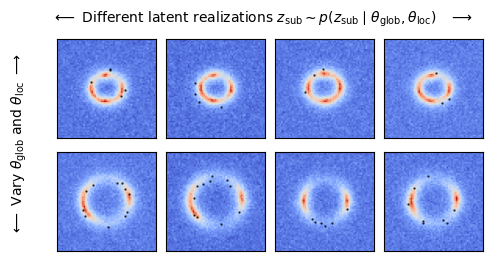

In [122]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(5.5, 2.8))
gs = GridSpec(2, 4)

for i in tqdm(range(8)):
    
    ax = fig.add_subplot(gs[i])
    ax.imshow(x[i // 4, i % 4].detach().numpy(), origin='lower', cmap='coolwarm', extent=[-3.2, 3.2, -3.2, 3.2])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
        
    for iloc, loc in enumerate(subs_trees[i]['z_x']):
        if loc[0] != 0.:
            plt.scatter(loc[0], loc[1], color='k', s=0.5, alpha=0.7)
        
fig.suptitle(r"$\longleftarrow$ Different latent realizations $ z_\mathrm{sub}\sim p(z_\mathrm{sub}\mid \theta_\mathrm{glob}, \theta_\mathrm{loc})$   $\longrightarrow$", fontsize=10)
fig.text(0.04, 0.5, r"$\longleftarrow$ Vary $\theta_\mathrm{glob}$ and $\theta_\mathrm{loc}$ $\longrightarrow$", va='center', rotation='vertical', fontsize=10)

plt.subplots_adjust(wspace=0.1, hspace=0.1)
# plt.tight_layout()

plt.savefig("../paper/figs/lensing_illustration.pdf", bbox_inches='tight')